In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.transforms import transforms
import matplotlib.pyplot as plt
import itertools
from training import toy

In [2]:
batch_size = 1

trainset = toy.CubicToyDataset(min=-4, max=4, sample_count=20, noise=3)
trainloader = torch.utils.data.DataLoader(trainset, batch_size)

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    print("No cuda device available; using the CPU")
    device = torch.device("cpu")

No cuda device available; using the CPU


In [4]:
def nll_loss(mean, variance, target):
    return (torch.log(variance) / 2 + torch.pow(target - mean, 2) / (2 * variance)).sum() / mean.shape[0]

In [9]:
nets = [nn.Sequential(nn.Linear(1, 100), nn.ReLU(), nn.Linear(100, 2)) for _ in range(5)]
for net in nets:
    optimizer = torch.optim.Adam(net.parameters())
    for epoch in range(40):
        for data, target in trainloader:
            optimizer.zero_grad()

            data.requires_grad = True # For the adversarial example
            target = target.squeeze(0)
            output = net(data)
            mean, variance = output[:,0], torch.log1p(torch.exp(output[:,1])) + 10e-6
            loss = nll_loss(mean, variance, target)
            loss.backward(retain_graph = True)

            # Adversarial examples
            a_data = data + 0.01 * torch.sign(data.grad)
            a_target = a_data**3
            a_output = net(data)
            a_mean, a_variance = a_output[:,0], torch.log1p(torch.exp(a_output[:,1])) + 10e-6
            a_loss = nll_loss(a_mean, a_variance, a_target)

            # Final optimizer step
            optimizer.zero_grad()
            loss = loss + a_loss
            loss.backward()
            optimizer.step()
    

C:\Users\flose\anaconda3\envs\ml\lib\site-packages\numpy\ma\core.py:2829: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  _data = np.array(data, dtype=dtype, copy=copy,
C:\Users\flose\anaconda3\envs\ml\lib\site-packages\numpy\ma\core.py:2829: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _data = np.array(data, dtype=dtype, copy=copy,


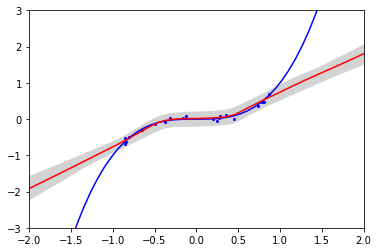

In [10]:
import matplotlib.pyplot as plt
from torchinfo import summary

plt.xlim(-2, 2)
plt.ylim(-3, 3)
t = np.linspace(-2, 2, 50)

plt.plot(t, t**3, color="blue") # Ground truth

with torch.no_grad():
    means, variances = torch.zeros((len(nets), t.shape[0])), torch.zeros((len(nets), t.shape[0]))
    for i, net in enumerate(nets):
        output = net(torch.from_numpy(t).unsqueeze(-1).float()).squeeze(-1)
        means[i] = output[:,0]
        variances[i] = torch.log1p(torch.exp(output[:,1])) + 10e-6
    mean = torch.mean(means, dim=0)
    higher_bound, _ = torch.max(means + 3 * torch.sqrt(variances), dim=0)
    lower_bound, _ = torch.min(means - 3 * torch.sqrt(variances), dim=0)
    plt.plot(t, mean, color="red") # Averaged predictions
    plt.fill_between(t, lower_bound, higher_bound, color="lightgrey")

xs, ys = zip(*trainset)
plt.scatter(xs, ys, s=4, color="blue")
#summary(nets[0], input_size=(batch_size, 1))